## Testing Plan

* Simple LLM interface : Send query, get result
* Single-shot and 5-shot
* Run over a shuffled version of the test set (and shown, with timing)

In [1]:
import os
import json, re
import random
import time, datetime, pytz

tz = pytz.timezone('Asia/Singapore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from solver.dataset import load_cryptonite_dataset, get_shuffled_idx

data_train =load_cryptonite_dataset('train') # Needed for multi-shot examples for ~GPT4 etc
shuffled_idx_train = get_shuffled_idx(data_train, seed=42)

data_val =load_cryptonite_dataset('val')
shuffled_idx_val = get_shuffled_idx(data_val, seed=42)

data_test=load_cryptonite_dataset('test')
shuffled_idx_test = get_shuffled_idx(data_test, seed=42)

len(data_val), len(data_test)

(26156, 26157)

In [4]:
def log_file_name(t, stub):  # stub='gemini'
  pth=f"./experiments/zero-shot/{stub}"
  os.makedirs(pth, exist_ok=True)
  #dt = time.strftime('%Y-%B-%d', time.gmtime(c['date']/1000)) #  %Y-%m-%d %H:%M:%S
  dt = time.strftime('%Y-%m-%d_%H-%M-%S', time.gmtime(t)) # Suitable for filename
  return f'{pth}/{dt}.log'

In [49]:
def run_samples(fn_get_model_response, stub, data_set, shuffled_idx, samples=10):
  t0=time.time()
  log_file = log_file_name(t0, stub)
  flog = open(log_file, 'a')

  pos, cnt = 0, 0
  for idx in range(samples):
    item = data_set[shuffled_idx[idx]]  
    ans_model = fn_get_model_response(item, flog=flog)
    ans_data  = item['answer'].upper()
    print(f'Correct:"{ans_data}", Model:"{ans_model}"')
    #print(test_item)
    if type(ans_model) is str and ans_model==ans_data:
      pos+=1
    if type(ans_model) is list and len(ans_model)>0:
      if type(ans_model[0]) is str and ans_model[0]==ans_data:
        pos+=1
    if type(ans_model) is tuple:  #  and len(ans_model)>0
      if type(ans_model[0]) is list and len(ans_model[0])>0:
        if type(ans_model[0][0]) is str and ans_model[0][0]==ans_data:
          pos+=1
    cnt+=1
    
    elapsed=(time.time()-t0)
    remaining=elapsed/cnt*(samples-cnt)
    eta_local = datetime.datetime.now(tz)+datetime.timedelta(seconds=remaining)
    print(f"@{idx:4d} : {pos:4d}/{samples:4d} correct={100.*pos/cnt:5.2f}% ({elapsed/cnt:5.2f}s/iter ETA:{eta_local.strftime('%Y-%m-%d %H:%M:%S %Z')})") # Remaining:{remaining:5.0f}s 
  
  flog.close()
  print(f"DONE : {100.*pos/cnt:7.2f}% correct in '{log_file}', ")

In [8]:
# Now let's compute the percentage correct from the log-file itself
#time.strftime('%Y-%B-%d', time.gmtime(1561766400000/1000))
def compute_score_from_logs(flog_arr, data_set, shuffled_idx, track_candidates=False):
  overlaid, overlaid_candidates = dict(), dict()
  for flog in flog_arr:
    with open(flog, 'r') as fin:
      for line in fin.readlines():
        if not '#RESULT#' in line: 
          continue
        if ':*:' in line:
          if track_candidates:
            _,idx_shuffled, idx_orig, ans, candidates = line.split(':*:')
          else:
            _,idx_shuffled, idx_orig, ans = line.split(':*:')
        else: # older version
          _,idx_shuffled, idx_orig, ans = line.split(':')
        idx_shuffled=int(idx_shuffled)
        overlaid[idx_shuffled]=ans.upper().strip()
        if track_candidates:
          overlaid_candidates[idx_shuffled]=candidates.upper().strip()
  # Now that we have the 'final' ans in overlaid, let's score them
  res_arr=[]
  pos, cnt = 0, 0
  pos_q, cnt_q = 0, 0
  pos_c, cnt_c = 0, 0  # Candidates maximum
  for idx, ans_model in overlaid.items():
    item = data_set[shuffled_idx[idx]]  
    ans_data  = item['answer'].upper()
    #print(f'@{idx: <4d} Model:"{ans_model}", Correct:"{ans_data}"')
    
    correct = (ans_model==ans_data)
    if correct:
      pos+=1
    cnt+=1
    if item['quick']:
      if correct:
        pos_q+=1
      cnt_q+=1
    res_arr.append( (correct, item['quick']) )
    if track_candidates:
      candidates = [c.strip() for c in overlaid_candidates[idx].split(',')]
      found=False
      for c in candidates:
        if c==ans_model: continue # Skip the candidate that we already know
        if c==ans_data:
          found=True
          break
      if found:
        pos_c+=1
      if len(candidates)>0:
        cnt_c+=1
    
  print(f"Overall : {pos:4d}/{cnt:4d} correct={100.*pos/cnt:5.2f}%")
  if cnt_q>0: 
    print(f"  Quick : {pos_q:4d}/{cnt_q:4d} correct={100.*pos_q/cnt_q:5.2f}%")
  print(f"   Hard : {pos-pos_q:4d}/{cnt-cnt_q:4d} correct={100.*(pos-pos_q)/(cnt-cnt_q):5.2f}%")
  if track_candidates:
    print(f"Candidates : {pos_c:4d}/{cnt_c:4d} correct={100.*pos_c/cnt_c:5.2f}%  << Uplift available")
  return res_arr
# ## Test the Gemini Model 'zero-shot'

### Gemini specific

In [67]:
prompt_basic="""
A Cryptic crossword question involves using the descriptive clue to yield an answer that matches the letter pattern.  
The clue will provide a definition of the answer, as well as some 'wordplay' that can also be used to confirm the answer.  
For example:

clue: "arrived with an artist, to get optical device (6)"
pattern: answer is 6 letters long
definition: arrived with an artist, to get {optical device}
wordplay: CAME (arrived) + RA (artist, short form)

```json
{
"answer": "CAMERA"
}
```

Please answer the following cryptic crossword clue, reasoning through the wordplay step-by-step, and give the answer in the JSON format as above:

""".lstrip()

In [68]:
from solver.llm import get_model #, CacheableLLM
base_model = get_model() 

In [71]:
def get_gemini_response(test_item, flog=None):
  prompt=(
    prompt_basic+
     f'''clue: "{test_item['clue']}"'''
  )
  #print(prompt)
  response = base_model.generate_content([prompt])
  #print(response)
  #print(f"{response.finish_reason=}")
  #print(f"{type(response.candidates[0].finish_reason)=}")
  #print(f"{response.candidates[0].finish_reason.name=}")
  response_text='BLOCKED'
  if len(response.candidates)>0 and response.candidates[0].finish_reason.name=='STOP':
    response_text = response.text
  ans='#NOTFOUND#'
  for line in response_text.split('\n'):
    # Parse the ```json``` section for "answer":
    if '"answer"' in line:
      arr = line.split(':')
      if len(arr)==2:
        ans=arr[1].replace('"', '').replace(':', '').strip().upper()  # Cannot contain quotes or ':'
        break
  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write(prompt)
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)
    flog.write(f"\n---#RESULT#---:*:{test_item['idx_shuffled']}:*:{test_item['idx_orig']}:*:{ans}\n")
  
  return ans

if False:
  idx=0
  test_item = data_test[shuffled_idx[idx]]
  print(test_item)
  print( get_gemini_response(test_item), test_item['answer'].upper() )

In [72]:
#run_samples(get_gemini_response, 'gemini', data_val, shuffled_idx_val, samples=515)
#run_samples(get_gemini_response, 'gemini', data_val, shuffled_idx_val[500:], samples=500)
#run_samples(get_gemini_response, 'gemini', data_val, shuffled_idx_val[950:], samples=50)

In [ ]:
#run_samples(get_gemini_response, 'gemini', data_test, shuffled_idx_test, samples=1000)

In [74]:
compute_score_from_logs([
  #'./experiments/zero-shot/gemini/2024-05-14_03-39-46.log',
  './experiments/zero-shot/gemini/2024-05-21_09-25-14.log', # Failed after 512 examples
  './experiments/zero-shot/gemini/2024-05-21_10-07-37.log', # Failed after +468 examples
  './experiments/zero-shot/gemini/2024-05-21_11-11-00.log', # Tail end
], data_val, shuffled_idx_val)

Overall :   33/1000 correct= 3.30%
  Quick :    8/  80 correct=10.00%
   Hard :   25/ 920 correct= 2.72%


In [77]:
compute_score_from_logs([
  './experiments/zero-shot/gemini/2024-05-14_03-39-46.log', # Has ':' as delimiter...
], data_test, shuffled_idx_test)

Overall :   30/1000 correct= 3.00%
  Quick :    7/  76 correct= 9.21%
   Hard :   23/ 924 correct= 2.49%


In [ ]:
# gemini : cryptonite.val  # 4-5sec per response
#Overall :   33/1000 correct= 3.30%
#  Quick :    8/  80 correct=10.00%
#   Hard :   25/ 920 correct= 2.72%

# gemini : cryptonite.test
#Overall :   30/1000 correct= 3.00%
#  Quick :    7/  76 correct= 9.21%
#   Hard :   23/ 924 correct= 2.49%

## Gemini Multi-shot Response

In [73]:
from solver.llm import get_model, RetryingLLM # , CacheableLLM
base_model = get_model(model_name="gemini-1.5-flash-001") 
base_model = RetryingLLM( base_model )  # Robustify Gemini Model...

Redis server is available and running.


In [89]:
def get_gemini_multishot_response(test_item, flog=None):
  prompt_arr=[]
  prompt_arr.append("""
**Instructions**  
You are an expert crossword solver. 
Given a clue please provide the best possible answer succinctly. Do not produce extra text.
The number of characters in the answer is given in brackets and must be strictly adhered to. 
e.g. Clue: Daily update(4) // means the answer should have 4 characters.
""".lstrip())
  
  prompt_arr.append(f"""
**Examples**
Clue: brawny greek character on sleigh catching cold (7) // MUSCLED
Clue: argument after diamonds say found in luggage (8) // SUITCASE
Clue: eirenic type, as leading athlete accepting last in race (10) // PEACEMAKER
Clue: asian leaders (but only one european) assembled in italian town (11) // ALESSANDRIA
Clue: winning, through living with aristocracy (5,5) // UPPER CRUST
""".lstrip())
    
  prompt_arr.append(f"""
**Task**
Clue: {test_item['clue']} // """.lstrip()
  )
  #print(prompt_arr)
  #return
  response = base_model.generate_content(prompt_arr)
  response_text='BLOCKED'
  if len(response.candidates)>0 and response.candidates[0].finish_reason.name=='STOP':
    response_text = response.text
  #ans='#NOTFOUND#'
  #print(response_text)
  ans=response_text.strip().upper()
  #for line in response_text.split('\n'):
  #  # Parse the ```json``` section for "answer":
  #  if '"answer"' in line:
  #    arr = line.split(':')
  #    if len(arr)==2:
  #      ans=arr[1].replace('"', '').replace(':', '').strip().upper()  # Cannot contain quotes or ':'
  #      break
  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write('\n'.join(prompt_arr))
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)
    flog.write(f"\n---#RESULT#---:*:{test_item['idx_shuffled']}:*:{test_item['idx_orig']}:*:{ans}\n")
  
  return ans

if True:
  idx=0
  test_item = data_test[shuffled_idx_test[idx]]
  print(test_item)
  print( get_gemini_multishot_response(test_item), test_item['answer'].upper() )

{'publisher': 'Telegraph', 'date': 1210291200000, 'author': None, 'number': '25', 'orientation': 'across', 'clue': 'one may have special tie on - - a nob, ob standing out? (7)', 'answer': 'etonian', 'enumeration': '(7)', 'quick': False, 'sub_publisher': None, 'idx_orig': 8117, 'idx_shuffled': 0}
KNOTLESS ETONIAN


In [95]:
#run_samples(get_gemini_multishot_response, 'gemini-flash-001', data_val, shuffled_idx_val, samples=1000)
#val :  DONE :    6.60% correct in './experiments/zero-shot/gemini-flash-001/2024-11-25_17-49-34.log', 
#run_samples(get_gemini_multishot_response, 'gemini-flash-001', data_test, shuffled_idx_test, samples=1000)
#test : DONE :    6.50% correct in './experiments/zero-shot/gemini-flash-001/2024-11-25_18-01-01.log', 

In [93]:
compute_score_from_logs([
  './experiments/zero-shot/gemini-flash-001/2024-11-25_17-49-34.log', 
], data_val, shuffled_idx_val)

Overall :   66/1000 correct= 6.60%
  Quick :   10/  80 correct=12.50%
   Hard :   56/ 920 correct= 6.09%


In [96]:
compute_score_from_logs([
  './experiments/zero-shot/gemini-flash-001/2024-11-25_18-01-01.log'
], data_test, shuffled_idx_test)

Overall :   65/1000 correct= 6.50%
  Quick :    9/  76 correct=11.84%
   Hard :   56/ 924 correct= 6.06%


### GPT4-Turbo specific

In [115]:
from solver.llm import get_model_openai
openai_client = get_model_openai()
completion = openai_client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": "write a haiku about ai"}
  ]
)
completion.choices[0].message.content

'Silent circuits hum—  \nBoundless thoughts in coded light—  \nDreams born of machine.'

In [116]:
completion

ChatCompletion(id='chatcmpl-AXYx0u8t5GoH13S66Sxb8jtdxMi2K', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Silent circuits hum—  \nBoundless thoughts in coded light—  \nDreams born of machine.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1732562538, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_7f6be3efb0', usage=CompletionUsage(completion_tokens=19, prompt_tokens=13, total_tokens=32, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [61]:
for idx in range(20):
  data_item=data_train[shuffled_idx_train[idx]]
  print(f"Clue: {data_item['clue']} // {data_item['answer'].upper()}")

Clue: shoot the messenger (6) // RUNNER
Clue: damp flu circulating -- one should protect against dirt on an estate (7) // MUDFLAP
Clue: eirenic type, as leading athlete accepting last in race (10) // PEACEMAKER
Clue: tried, having cheated in the past (3,1,2) // HAD A GO
Clue: asian leaders (but only one european) assembled in italian town (11) // ALESSANDRIA
Clue: brawny greek character on sleigh catching cold (7) // MUSCLED
Clue: this explained baffling script, getting half of team in favour (7,5) // ROSETTA STONE
Clue: bride asked to reveal thoughts (5) // IDEAS
Clue: argument after diamonds say found in luggage (8) // SUITCASE
Clue: superficial polish an anglican cleric always displays (6) // VENEER
Clue: opera on box including one english standard (9) // NORMATIVE
Clue: one seeking political change -- once soldiers get precedence (8) // REFORMER
Clue: book a restaurant? can be achieved (8) // GETTABLE
Clue: one cutting in or abandoning one on world tour (5) // BITER
Clue: associate

In [64]:
def get_gpt4_multishot_response(test_item, flog=None):
  system_content = """
You are an expert crossword solver. 
Given a clue please provide the best possible answer succinctly. Do not produce extra text.**
The number of characters in the answer is given in brackets and must be strictly adhered to. 
e.g. Clue: Daily update(4) // means the answer should have 4 characters.""".replace("\n", "").replace("**", "\n")

  prompt_content = f"""
Clue: brawny greek character on sleigh catching cold (7) // MUSCLED
Clue: argument after diamonds say found in luggage (8) // SUITCASE
Clue: eirenic type, as leading athlete accepting last in race (10) // PEACEMAKER
Clue: asian leaders (but only one european) assembled in italian town (11) // ALESSANDRIA
Clue: winning, through living with aristocracy (5,5) // UPPER CRUST
Clue: {test_item['clue']} // """.lstrip()
  
  completion = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
      { "role":"system",  "content": system_content },
      { "role":"user",    "content": prompt_content },
    ]
  )
  
  response_text='BLOCKED'
  if len(completion.choices)>0:  #  and response.candidates[0].finish_reason.name=='STOP'
    response_text = completion.choices[0].message.content
  response_text = response_text.strip().upper()
  ans = response_text
  #for line in response_text.split('\n'):
  #  # Parse the ```json``` section for "answer":
  #  if '"answer"' in line:
  #    arr = line.split(':')
  #    if len(arr)==2:
  #      ans=arr[1].replace('"', '').replace(':', '').strip().upper()  # Cannot contain quotes or ':'
  #      break
  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write(prompt_content)
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)
    flog.write(f"\n---#RESULT#---:*:{test_item['idx_shuffled']}:*:{test_item['idx_orig']}:*:{ans}\n")
  
  return ans

if True:
  idx=0
  test_item = data_test[shuffled_idx_test[idx]]
  print(test_item)
  print( get_gpt4_multishot_response(test_item), test_item['answer'].upper() )  

{'publisher': 'Telegraph', 'date': 1210291200000, 'author': None, 'number': '25', 'orientation': 'across', 'clue': 'one may have special tie on - - a nob, ob standing out? (7)', 'answer': 'etonian', 'enumeration': '(7)', 'quick': False, 'sub_publisher': None, 'idx_orig': 8117, 'idx_shuffled': 0}
BOWTIEO ETONIAN


In [121]:
# run_samples(get_gpt4_multishot_response, 'gpt-4o', data_val, shuffled_idx_val, samples=1000)
# val :  DONE :   29.80% correct in './experiments/zero-shot/gpt-4o/2024-11-25_17-29-22.log',
#run_samples(get_gpt4_multishot_response, 'gpt-4o', data_test, shuffled_idx_test, samples=1000)
# test : DONE :   27.60% correct in './experiments/zero-shot/gpt-4o/2024-11-25_16-24-28.log', 

In [11]:
arr=compute_score_from_logs([
  './experiments/zero-shot/gpt-4o/2024-11-25_17-29-22.log',
], data_val, shuffled_idx_val)

Overall :  298/1000 correct=29.80%
  Quick :   36/  80 correct=45.00%
   Hard :  262/ 920 correct=28.48%


In [9]:
arr=compute_score_from_logs([
  './experiments/zero-shot/gpt-4o/2024-11-25_16-24-28.log',   
], data_test, shuffled_idx_test)

Overall :  276/1000 correct=27.60%
  Quick :   36/  76 correct=47.37%
   Hard :  240/ 924 correct=25.97%


In [12]:
if False:
  with open("./paper/2024-09-28_ICLR/IRT/val_gpt4o.txt", 'wt') as f:
    f.write(f"correct,is_quick\n")  
    for a in arr:
      f.write(f"{a[0]:d},{a[1]:d}\n")

## Test Gemma2-9B-it multi-shot

In [98]:
from omegaconf import OmegaConf
conf = OmegaConf.load('config.yaml')

In [99]:
from together import Together
from solver.llm import FakeGeminiResponse, gemma2it_prompt

class ModelGemma2it_together(object):
  client = None
  def __init__(self):
    self.client = Together(api_key=conf.APIKey.TOGETHER_AI)
    
  # See other notes in 0_explore_dataset.py
  def generate_single(self, input_templated, temperature=0.5, max_new_tokens=256):
    response = self.client.completions.create(
      model="google/gemma-2-9b-it", 
      prompt=input_templated,
      max_tokens=max_new_tokens,
      temperature=temperature,
      #top_p=0.7, #top_k=50, #repetition_penalty=1,
      stop=["<end_of_turn>","<eos>"],  #stream=True,
    )
    return response.choices[0].text
    
  def generate_content(self, prompt_parts):
    prompts = gemma2it_prompt('', ''.join(prompt_parts), 'NOTTRAINING')
    output_txt = self.generate_single(prompts['prompt_test'])
    return FakeGeminiResponse(output_txt) 

In [100]:
base_model = ModelGemma2it_together()

In [102]:
#t0=time.time()
#print( base_model.generate_content(["What is 2+2?"]).text )
#print(f"{(time.time()-t0):.2f}sec")
# 0.42sec

In [104]:
def get_gemma2_9B_it_multishot_response(test_item, flog=None):
  prompt_arr=[]
  prompt_arr.append("""
**Instructions**  
You are an expert crossword solver. 
Given a clue please provide the best possible answer succinctly. Do not produce extra text.
The number of characters in the answer is given in brackets and must be strictly adhered to. 
e.g. Clue: Daily update(4) // means the answer should have 4 characters.
""".lstrip())
  
  prompt_arr.append(f"""
**Examples**
Clue: brawny greek character on sleigh catching cold (7) // MUSCLED
Clue: argument after diamonds say found in luggage (8) // SUITCASE
Clue: eirenic type, as leading athlete accepting last in race (10) // PEACEMAKER
Clue: asian leaders (but only one european) assembled in italian town (11) // ALESSANDRIA
Clue: winning, through living with aristocracy (5,5) // UPPER CRUST
""".lstrip())
    
  prompt_arr.append(f"""
**Task**
Clue: {test_item['clue']} // """.lstrip()
  )
  #print(prompt_arr)
  #return
  response = base_model.generate_content(prompt_arr)
  response_text='BLOCKED'
  if len(response.candidates)>0 and response.candidates[0].finish_reason.name=='STOP':
    response_text = response.text
  #ans='#NOTFOUND#'
  #print(response_text)
  ans=response_text.strip().upper()
  #for line in response_text.split('\n'):
  #  # Parse the ```json``` section for "answer":
  #  if '"answer"' in line:
  #    arr = line.split(':')
  #    if len(arr)==2:
  #      ans=arr[1].replace('"', '').replace(':', '').strip().upper()  # Cannot contain quotes or ':'
  #      break
  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write('\n'.join(prompt_arr))
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)
    flog.write(f"\n---#RESULT#---:*:{test_item['idx_shuffled']}:*:{test_item['idx_orig']}:*:{ans}\n")
  
  return ans

if True:
  idx=0
  test_item = data_test[shuffled_idx_test[idx]]
  print(test_item)
  print( get_gemma2_9B_it_multishot_response(test_item), test_item['answer'].upper() )

{'publisher': 'Telegraph', 'date': 1210291200000, 'author': None, 'number': '25', 'orientation': 'across', 'clue': 'one may have special tie on - - a nob, ob standing out? (7)', 'answer': 'etonian', 'enumeration': '(7)', 'quick': False, 'sub_publisher': None, 'idx_orig': 8117, 'idx_shuffled': 0}
TASSEL ETONIAN


In [112]:
#run_samples(get_gemma2_9B_it_multishot_response, 'gemma2-9B-it', data_val, shuffled_idx_val, samples=1000)
#val :  DONE :    5.70% correct in './experiments/zero-shot/gemma2-9B-it/2024-11-25_18-28-26.log', 
#run_samples(get_gemma2_9B_it_multishot_response, 'gemma2-9B-it', data_test, shuffled_idx_test, samples=1000) # Internet went down
#run_samples(get_gemma2_9B_it_multishot_response, 'gemma2-9B-it', data_test, shuffled_idx_test[944:], samples=57)
#run_samples(get_gemma2_9B_it_multishot_response, 'gemma2-9B-it', data_test, shuffled_idx_test[990:], samples=15)
#test : In sections...

In [113]:
compute_score_from_logs([
  './experiments/zero-shot/gemma2-9B-it/2024-11-25_18-28-26.log', 
], data_val, shuffled_idx_val)

Overall :   57/1000 correct= 5.70%
  Quick :    9/  80 correct=11.25%
   Hard :   48/ 920 correct= 5.22%


In [114]:
compute_score_from_logs([
  './experiments/zero-shot/gemma2-9B-it/2024-11-25_18-50-17.log',   # Up to 945  Model:"HOGARTH AND"
  './experiments/zero-shot/gemma2-9B-it/2024-11-25_19-18-14.log',  
  './experiments/zero-shot/gemma2-9B-it/2024-11-25_19-21-02.log', 
], data_test, shuffled_idx_test)

Overall :   45/1000 correct= 4.50%
  Quick :    8/  76 correct=10.53%
   Hard :   37/ 924 correct= 4.00%


## Run now with LocalLLM (Fine-tuned on cryptonite.train)

In [ ]:
import os
from unsloth import FastLanguageModel
import torch

HFCOMPANY=os.environ.get("HFCOMPANY", "cryptic-wordplay-formalizer")

max_seq_length = 512
dtype = None
load_in_4bit = True
"DONE", HFCOMPANY

In [ ]:
model, tokenizer = None, None
def load_model_and_tokenizer(model_name):
  global model, tokenizer
  model, tokenizer = None, None

  model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
  )
  
  FastLanguageModel.for_inference(model) # Faster inference
  print("LOADED")

## Use the (Sam Pretrained) Local LLM with answer-only pretraining

In [ ]:
load_model_and_tokenizer(f"{HFCOMPANY}/llama3_cryptonite_1_epoch")

In [ ]:
def get_local_llm_response(example, flog=None):
  clue = example['clue']
  answer = example['answer']
  enumeration = example['enumeration']
  orientation = example['orientation']
  
  system = f"""You are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer"""
  user = f'''CLUE: {clue} \n ORIENTATION: the word is {enumeration} letters long and goes {orientation}\n'''.lstrip()
  assistant = f'''ANSWER: {answer}'''

  text = f'''<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>

{user}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n{assistant}<|eot_id|><|end_of_text|>'''
  prompt = f'''<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>

{user}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n'''
  
  #prompt=(
  #  prompt_basic+
  #   f'''clue: "{test_item['clue']}"'''
  #)
  #print(prompt)
  inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True, pad_token_id=tokenizer.eos_token_id)
  
  response_text =  tokenizer.batch_decode(outputs)[0] 
  #print(response_text)
  # ANSWER: anorak<|eot_id|><|end_of_text|>

  ans='#NOTFOUND#'
  for line in response_text.split('\n'):
    # Parse the ```json``` section for "answer":
    if 'ANSWER:' in line:
      arr = line.split('ANSWER:')
      if len(arr)==2:
        ans=arr[1].replace('"', '').replace(':', '').strip().upper()  # Cannot contain quotes or ':'
        if '<' in ans:  # Parse off the end-of-response tokens
          ans = ans[:ans.index('<')]
        break
  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write(prompt)
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)
    flog.write(f"\n---#RESULT#---:*:{example['idx_shuffled']}:*:{example['idx_orig']}:*:{ans}\n")
  
  return ans

if True:
  idx=0
  item = data_val[shuffled_idx_val[idx]]
  print(item)
  print( get_local_llm_response(item), item['answer'].upper() )

In [ ]:
run_samples(get_local_llm_response, 'llama3_cryptonite_1_epoch', data_val, shuffled_idx_val, samples=1000)

In [ ]:
run_samples(get_local_llm_response, 'llama3_cryptonite_1_epoch', data_test, shuffled_idx_test, samples=1000)
# cell cleared to avoid revealing test data

In [ ]:
compute_score_from_logs([
  #'./experiments/zero-shot/llama3_cryptonite_1_epoch/2024-05-21_08-19-31.log', # 2/10 0q 2h run for code testing
  #'./experiments/zero-shot/llama3_cryptonite_1_epoch/2024-05-21_08-21-40.log',  # 195/1000 23/80q 171/920h
  './experiments/zero-shot/llama3_cryptonite_1_epoch/2024-05-21_08-49-41.log', 
], data_val, shuffled_idx_val)

In [ ]:
compute_score_from_logs([
  #'./experiments/zero-shot/llama3_cryptonite_1_epoch/2024-05-21_07-30-10.log',  # 17/100 2q 15h,
  #'./experiments/zero-shot/llama3_cryptonite_1_epoch/2024-05-21_07-32-23.log',  # 156/1000 25/76q 131/924h
  './experiments/zero-shot/llama3_cryptonite_1_epoch/2024-05-21_08-37-41.log',   # 143/1000 23/76q 120/924h
], data_test, shuffled_idx_test)

In [ ]:
# llama3-8B-FT : cryptonite val:   # 0.6-0.7 sec per response
#Overall :  188/1000 correct=18.80%
#  Quick :   25/  80 correct=31.25%
#   Hard :  163/ 920 correct=17.72%

# llama3-8B-FT : cryptonite test:
#Overall :  143/1000 correct=14.30%
#  Quick :   23/  76 correct=30.26%
#   Hard :  120/ 924 correct=12.99%

## Use the Local LLM with answer+candidates pretraining

In [ ]:
load_model_and_tokenizer(f"{HFCOMPANY}/llama3_cryptonite_candidates_1_epoch")

In [ ]:
def get_local_llm_response_with_candidates(example, flog=None):
  clue = example['clue']
  answer = example['answer']
  enumeration = example['enumeration']
  orientation = example['orientation']

  system = f"""You are a Master Cryptic Crossword solver. Take the following clue and think carefully to come up with 5 candidate answers, and then pick the best answer from those candidates"""
  user   = f'''CLUE: {clue}\nORIENTATION: the answer is {enumeration} letters long and goes {orientation}\n'''.lstrip()

  prompt = f'''<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>

{user}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n'''

  inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True, pad_token_id=tokenizer.eos_token_id)
  
  response_text =  tokenizer.batch_decode(outputs)[0] 
  #print(response_text)
  # ??? CANDIDATES: ???
  # ANSWER: anorak<|eot_id|><|end_of_text|>

  ans, candidates = '#NOTFOUND#', '#NOTFOUND#'
  for line in response_text.split('\n'):
    # Parse the ```json``` section for "answer":
    if 'CANDIDATES:' in line:
      arr = line.split('CANDIDATES:')
      if len(arr)==2:
        candidates = arr[1].replace('"', '').replace(':', '').strip().upper()
        if '<' in candidates:  # Parse off the end-of-response tokens : SHOULD NOT HAPPEN!
          candidates = candidates[:candidates.index('<')]
    if 'ANSWER:' in line:
      arr = line.split('ANSWER:')
      if len(arr)==2:
        ans=arr[1].replace('"', '').replace(':', '').strip().upper()  # Cannot contain quotes or ':'
        if '<' in ans:  # Parse off the end-of-response tokens
          ans = ans[:ans.index('<')]
        break
  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write(prompt)
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)
    flog.write(f"\n---#RESULT#---:*:{example['idx_shuffled']}:*:{example['idx_orig']}:*:{ans}:*:{candidates}\n")
  
  return ans

if True:
  idx=0
  item = data_val[shuffled_idx_val[idx]]
  print(item)
  print( get_local_llm_response_with_candidates(item), item['answer'].upper() )

In [ ]:
#run_samples(get_local_llm_response_with_candidates, 'llama3_cryptonite_candidates_1_epoch', data_val, shuffled_idx_val, samples=10)
run_samples(get_local_llm_response_with_candidates, 'llama3_cryptonite_candidates_1_epoch', data_val, shuffled_idx_val, samples=1000)

In [ ]:
run_samples(get_local_llm_response_with_candidates, 'llama3_cryptonite_candidates_1_epoch', data_test, shuffled_idx_test, samples=1000)

In [ ]:
compute_score_from_logs([
  #'./experiments/zero-shot/llama3_cryptonite_candidates_1_epoch/2024-05-22_13-26-08.log',  # 0/10 trial run
  './experiments/zero-shot/llama3_cryptonite_candidates_1_epoch/2024-05-22_13-29-23.log',
], data_val, shuffled_idx_val, track_candidates=True)

In [ ]:
compute_score_from_logs([
  './experiments/zero-shot/llama3_cryptonite_candidates_1_epoch/2024-05-22_14-38-58.log',
], data_test, shuffled_idx_test, track_candidates=True)

In [ ]:
# answer+candidates model : val
#Overall :   70/1000 correct= 7.00%
#  Quick :   11/  80 correct=13.75%
#   Hard :   59/ 920 correct= 6.41%
#Candidates :   24/1000 correct= 2.40%  << Uplift available

# answer+candidates model : test
#Overall :   65/1000 correct= 6.50%
#  Quick :    8/  76 correct=10.53%
#   Hard :   57/ 924 correct= 6.17%
#Candidates :   23/1000 correct= 2.30%  << Uplift available

## Use the (new) Local LLM with answer pretraining to generate multiple answer guesses

In [7]:
## Look at the crossword words dataset
from solver.corpora import CrosswordDictionary
crossword_dictionary = CrosswordDictionary(None)
print(len(crossword_dictionary.wordlist), crossword_dictionary.wordlist[0:100:10])

Loading as_lower_case=True embeddings took 0.0243s
304658 ['a', 'aaronical', 'abaca', 'abacuses', 'abalone', 'abandoning', 'abased', 'abashment', 'abating', 'abattoir']


In [ ]:
##load_model_and_tokenizer(f"{HFCOMPANY}/llama3_cryptonite_1_epoch")
#load_model_and_tokenizer(f"./llama3.1-it_answer_guesser_1200_steps")
#load_model_and_tokenizer(f"./llama3.1-it_answer_guesser_1200_steps_resp-only") # BASE-CASE
#load_model_and_tokenizer(f"./llama3.1-it_answer_guesser_1200_steps_resp-only_expert")
#load_model_and_tokenizer(f"./llama3-it_answer_guesser_1200_steps_resp-only")
#load_model_and_tokenizer(f"./gemma2-9B_answer_guesser_1200_steps_resp-only")
#load_model_and_tokenizer(f"./gemma2-2B_answer_guesser_1200_steps_resp-only")
#load_model_and_tokenizer(f"./llama3.1-base_answer_guesser_1200_steps_resp-only")
#load_model_and_tokenizer(f"./llama3.1-it_answer_guesser_1200_steps_resp-only_r32")

# Base ICLR clue->answer
load_model_and_tokenizer(f"./gemma2-9B_answer_guesser_3678_steps_resp-only")

#load_model_and_tokenizer(f"./gemma2-9B_answer_guesser_1200_steps_resp-only_upper")

#load_model_and_tokenizer(f"./llama3.1-it_answer_guesser_1200_steps_resp-only_do-over-v1")

In [8]:
import solver.dataset
from solver import llm
from solver import pattern_to_re

Redis server is available and running.


In [ ]:
#llm_prompt_style = llm.llama3_prompt
llm_prompt_style = llm.alpaca_prompt

upper_case_too=False
#upper_case_too=True

def get_answer_response_multiple(data_item, flog=None, 
                                 responses=20, 
                                 num_return_sequences=16, remaining_attempts=5,   # 5*16=80>>20
                                 #num_return_sequences=8, remaining_attempts=1,   # for do-over training
                                 reject_clue_fragments=True, debug=False, 
                                 upper_case_too=upper_case_too,
                                 temperature=0.5):  # 0.5 Ok for Llama3, and higher @1 for Gemma2
                                 #temperature=1.0):  #1.0 may be more suitable for Gemma2 diversity
  clue_no_def = data_item['clue'].replace('{','').replace('}','').strip()
  enumeration = data_item['enumeration']
  orientation = data_item['orientation']

  prompts = llm.prompt_answer_guesser(llm_prompt_style, clue_no_def, enumeration, orientation, '')  # Don't send answer...
  prompt = prompts['prompt_test']
  if debug or True:
    print(f"{orientation}: {clue_no_def}")  # includes enumeration

  inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
  prompt_length = inputs['input_ids'].shape[1]

  def eot_truncate(ans, eot):
    if eot in ans:
      pos = ans.index(eot)
      ans = ans[:pos]
    return ans

  clue_no_def_words_uc = clue_no_def.upper().split(' ')
  pattern = enumeration.replace('(', '').replace(')', '')
  pattern_re = pattern_to_re(pattern)

  answers_valid, answers_in_clue, answers_wrong_pattern, answers_logprob = [], [], [], dict()
  while len(answers_valid)<responses and remaining_attempts>0:
    #outputs = model.generate(**inputs, max_new_tokens=40,  # Old version - just for tokens
    output_stuff = model.generate(**inputs, max_new_tokens=40,  
                             use_cache=True, pad_token_id=tokenizer.eos_token_id, 
                             temperature=temperature, do_sample=True, 
                             num_return_sequences=num_return_sequences,
                             return_dict_in_generate=True,   # New line here 
                             #output_logits=True, # New line here - returns a large array
                             output_scores=True,  # New line here - returns just the processed logits(?) of the tokens output
                            )
    #print(dir(output_stuff))

    if False:
      # Works with output_logits=True
      #print(f"{output_stuff.logits[0].shape=}") #output_stuff.logits[0].shape=torch.Size([16, 256000])
      #print(f"{output_stuff['logits'][0]=}")
      #print(f"{output_stuff.logits[0]=}")
  
      print(f"{prompt_length=}")
      print(f"{len(output_stuff.scores)=}")       # len(output_stuff.scores)=4   # This is the number of output token steps [t]
      print(f"{output_stuff.scores[0].shape=}")   # output_stuff.scores[0].shape=torch.Size([16, 256000])  [B, vocab]
      print(f"{len(output_stuff['sequences'])=}") # len(output_stuff['sequences'])=16 [B}
      print(f"{output_stuff['sequences'][0].shape=}")  # output_stuff['sequences'][0].shape=torch.Size([57]) [t]

    # Return only new(ish) tokens : Need to back off a little... (since 'answer: ' is in prompt)
    outputs = output_stuff['sequences'] # ?
    #print(outputs[0, prompt_length-10:])  # Search for <EOS>...  ==1 !?!
    # tensor([ 39736, 235292,   7285,    109,   6176,  10567, 235292,    108,  13072, 235292,  27765,   8479,    108,      1], device='cuda:0')
    response_text_arr =  tokenizer.batch_decode(outputs[:, prompt_length-10:])
    #return {}  # For time-trials
    
    for response_idx, response_text in enumerate(response_text_arr):
      #print(f"RESPONSE:{response_idx}\n{response_text}\n")

      logprobs = []
      with torch.no_grad():
        for timestep, scores in enumerate(output_stuff.scores):
          response_timestep_scores = scores[response_idx]  # This is the scores (~logits) for this timestep
          #print(f"{response_timestep_scores.shape=}")
          response_timestep_logprobs = torch.log_softmax(response_timestep_scores, dim=-1)
          output_token = outputs[response_idx, prompt_length+timestep]
          logprobs.append( response_timestep_logprobs[output_token].item() )
          if output_token==1: 
            #print(f"Got <eos> at {timestep=}")
            break # This is <eos>
      response_logprob = sum(logprobs) / len(logprobs)
      #print(f"{response_logprob=}")
      
      fields, count_found, finished = { 'answer:':None, }, 0, False
      for line in response_text.split('\n'):
        line = line.strip()
        #print(f'{line=}')
        for k,v in fields.items():
          if line.startswith(k) and v is None:
            #print(f'Got:{k}')
            ans = line[len(k):].strip()
            ans = eot_truncate(ans, '<|end_of_text|>')
            ans = eot_truncate(ans, '<|eot_id|>')
            if '#' in ans: # This is for the do-over stuff
              if 'No' in ans[ans.find('#'):]: # This is a rejection
                #print(f"Discarding '{ans}'")
                break # i.e. ignore this line
              ans = eot_truncate(ans, '#')  
            #print(f"Accepting '{ans}'")
            fields[k]=ans.strip()
            count_found+=1
            if count_found==len(fields):
              finished=True
            break
        if finished:
          break
      answer = fields['answer:']
      if answer is not None and len(answer)>0:
        answer = answer.upper()
        if upper_case_too:  # The answer needs 'de-spacing'
          #tmp=answer
          answer = llm.from_upper_tokens(answer)
          #print(f"'{tmp}' -> '{answer}'")
        found=False
        if reject_clue_fragments:
          for w in clue_no_def_words_uc:
            if answer in w:
              found=True
          if found:
            answers_in_clue.append(answer)
            if debug:
              print(f"Rejecting '{answer}' - in clue")
        if not found:
          # CHECK THAT IT FITS THE PATTERN...
          if re.match(pattern_re, answer):
            answers_valid.append(answer)
            answers_logprob[answer]=response_logprob  # This will overwrite - the logprobs are deterministic given previous sequence
          else:
            answers_wrong_pattern.append(answer)
            if debug:
              print(f"Rejecting '{answer}' - doesn't match pattern {enumeration}")
    #print(f"{len(answers_valid)=}")
    remaining_attempts-=1

  if flog is not None:
    flog.write('\n---PROMPT---\n')
    flog.write(prompt)
    flog.write('\n---RESPONSE---\n')
    flog.write(response_text)   # This is just the last response text...
    solver.dataset.write_log_result(flog, data_item['idx_shuffled'], data_item['idx_orig'], dict(
      clue=clue_no_def,
      pattern=pattern,
      answers_valid=answers_valid[:responses],  # Restrict the number of responses to that requested
      answers_wrong_pattern=answers_wrong_pattern,
      answers_in_clue=answers_in_clue,
      answers_logprob=answers_logprob,
    ))
  
  return answers_valid, answers_wrong_pattern, answers_in_clue, answers_logprob

In [ ]:
if True:  # Check 1 validation example
  idx=3
  data_item = data_val[shuffled_idx_val[idx]]
  answers_valid, answers_wrong_pattern, answers_in_clue, answers_logprob = get_answer_response_multiple(data_item, debug=True)
  print(f"""  answer: gold='{ data_item['answer'].upper() }'""" )  
  print(f"""          model:'{ ','.join(answers_valid) }'""")
  print(f"""          answers_wrong_pattern:'{ ','.join(answers_wrong_pattern) }'""")
  print(f"""          answers_in_clue:'{ ','.join(answers_in_clue) }'""")
  for k in sorted(answers_logprob.keys(), key=lambda k:-answers_logprob[k]):
    print(f"""          answers_logprob[{k}]->{answers_logprob[k]:.4f}""")

In [ ]:
if False:  # For running a time-trial
  n=1
  for _ in range(8):
    t0=time.time()
    get_answer_response_multiple(data_item, responses=1, num_return_sequences=n)
    print(f"n={n:4d} : {(time.time()-t0):.4f}secs overall, {(time.time()-t0)/n:.4f}secs per sample")
    n*=2
"""
across: little bird to dart across sill (10)
n=   1 : 0.6424secs overall, 0.6424secs per sample
n=   2 : 1.5656secs overall, 0.7828secs per sample
n=   4 : 1.6869secs overall, 0.4217secs per sample
n=   8 : 1.8867secs overall, 0.2358secs per sample
n=  16 : 2.3012secs overall, 0.1438secs per sample
n=  32 : 3.1910secs overall, 0.0997secs per sample
n=  64 : 4.6393secs overall, 0.0725secs per sample
n= 128 : 7.9338secs overall, 0.0620secs per sample
""";

In [ ]:
run_samples(get_answer_response_multiple, 'gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0_dumbranker', 
            data_test, shuffled_idx_test, samples=515)
#run_samples(get_answer_response_multiple, 'gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0_dumbranker', 
#            data_val, shuffled_idx_val, samples=1000) # Only ran for 515

In [9]:
import solver.dataset
def compute_multiple_answer_scoring_from_logs(overlaid, data_set, shuffled_idx, 
                                              whole_list=False, most_popular=False, 
                                              only_valid_answers=False, logprobs=False,
                                              valid_responses_max=20, debug=True):
  # Now that we have the 'final' ans in overlaid, let's score them
  pos, cnt = 0, 0
  pos_q, cnt_q = 0, 0  # Quick (not hard)
  
  for idx, model_outputs in overlaid.items():
    #if idx>=200: break  # Doesn't change the answer much (phew!)
    item = data_set[shuffled_idx[idx]]  
    ans_data  = item['answer'].upper()
    #print(f'@{idx: <4d} Model:"{ans_model}", Correct:"{ans_data}"')
    model_data = model_outputs[0]
    model_answers=model_data['answers_valid']

    model_answers=model_answers[:valid_responses_max]  # cut off the list... (should be done above)
    if only_valid_answers:
      model_answers = [ answer for answer in model_answers if crossword_dictionary.includes(answer, split_phrase=True) ]
    
    correct=None
    if whole_list:
      correct = (ans_data in model_answers) # Search list
    if most_popular:  # Idea: Is the most popular one the right one?
      # https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
      if len(model_answers)>0: 
        most_frequent = max(set(model_answers), key=model_answers.count)
        correct = (ans_data == most_frequent)
    if logprobs and 'answers_logprob' in model_data:
      answers_logprob = model_data['answers_logprob']
      logprobs_sorted = sorted(answers_logprob.keys(), key=lambda k:-answers_logprob[k])
      if len(logprobs_sorted)>0:
        correct = (ans_data == logprobs_sorted[0])
    if correct is None:  # Nothing done yet - just use the first model_answer (if available)
      correct = (len(model_answers)>0 and model_answers[0]==ans_data) # Single value
      
    if correct: pos+=1
    cnt+=1
    if item['quick']:
      if correct: pos_q+=1
      cnt_q+=1

  if debug:
    print(f"Overall : {pos:4d}/{cnt:4d} correct={100.*pos/cnt:5.2f}%")
    if cnt_q>0: 
      print(f"  Quick : {pos_q:4d}/{cnt_q:4d} correct={100.*pos_q/cnt_q:5.2f}%")
    print(f"   Hard : {pos-pos_q:4d}/{cnt-cnt_q:4d} correct={100.*(pos-pos_q)/(cnt-cnt_q):5.2f}%")

  return pos, cnt, pos_q, cnt_q

In [10]:
pth='./experiments/zero-shot/'
log_outputs_for_analysis = [
  # all against test set...
  pth+'llama3.1-it_answer_guesser_1200_steps/2024-08-31_18-10-17.log', # 11.10% correct
  pth+'llama3.1-it_answer_guesser_1200_steps_resp-only/2024-09-01_08-01-53.log', # 13.30% correct - 26.6% whole list BASE-CASE
  pth+'llama3.1-it_answer_guesser_1200_steps_resp-only_expert/2024-09-02_16-42-35.log', # 13.20% correct - 25.4% whole list
  pth+'llama3-it_answer_guesser_1200_steps_resp-only/2024-09-03_08-08-45.log', # 13.00% correct
  pth+'gemma2-9B_answer_guesser_1200_steps_resp-only/2024-09-03_05-56-00.log', # 16.80% correct - 37.3% whole list
  pth+'gemma2-2B_answer_guesser_1200_steps_resp-only/2024-09-03_12-46-30.log', # 8.00% correct - 23.3% whole list
  pth+'gemma2-9B_answer_guesser_1200_steps_resp-only_t-1.0/2024-09-03_13-37-23.log',  # 12.30% - 43.4% whole list
  pth+'llama3.1-base_answer_guesser_1200_steps_resp-only/2024-09-04_02-57-01.log', # 13.80% correct - 26.40% whole list
  pth+'llama3.1-it_answer_guesser_1200_steps_resp-only_r32/2024-09-04_14-10-44.log', # 13.20% correct - 26.20% whole list
  pth+'llama3.1-it_answer_guesser_1200_steps_resp-only_do-over-v1/2024-09-04_17-29-40.log',   # 15.20% correct = 29.30% whole list

  pth+'gemma2-9B_answer_guesser_1200_steps_resp-only_upper/2024-09-16_17-23-24.log', # 9.00% correct - 26.1% whole list

  # NB: test set...
  pth+'gemma2-9B_answer_guesser_3678_steps_resp-only/2024-09-06_13-37-15.log',       # 21.20% correct - 40.0% whole list
  pth+'gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0/2024-09-06_15-59-09.log', # 15.90% correct - 44.20% whole list

  # NB: validation set...
  pth+'gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0/2024-09-26_05-20-39.log', # *val* 21.70% correct

  # NB: validation set... has 515 (with logprobs)
  pth+'gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0_dumbranker/2024-11-26_19-13-40.log', # 21.30% correct - 38.4% whole list
  # | gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0_dumbranker | 21.39% | 33.33% | 20.42% || 38.54% | 46.15% | 37.92% || 23.89% | 35.90% | 22.92% |

  pth+'gemma2-9B_answer_guesser_3678_steps_resp-only_t-1.0_dumbranker/2024-11-27_07-29-10.log', # TBA
]

In [11]:
# original llama3-7B-base for 1 epoch = 14.30%
overlaid = solver.dataset.read_log_results([log_outputs_for_analysis[-1]]) # Just the last entry
for whole_list in [False, True]:
  print(f"Examining whole list={whole_list}")
  compute_multiple_answer_scoring_from_logs( overlaid, data_test, shuffled_idx_test, whole_list=whole_list)
  #compute_multiple_answer_scoring_from_logs( overlaid, data_val, shuffled_idx_val, whole_list=whole_list)  
#compute_multiple_answer_scoring_from_logs( overlaid, data_val, shuffled_idx_val, logprobs=True)  

Examining whole list=False
Overall :  217/1000 correct=21.70%
  Quick :   23/  80 correct=28.75%
   Hard :  194/ 920 correct=21.09%
Examining whole list=True
Overall :  385/1000 correct=38.50%
  Quick :   33/  80 correct=41.25%
   Hard :  352/ 920 correct=38.26%


In [13]:
# Now do whole list with 'all kinds of outputs'
def compute_with_args(overlaid, **kwargs):
  return compute_multiple_answer_scoring_from_logs( overlaid, data_test, shuffled_idx_test, debug=False, **kwargs)
  #return compute_multiple_answer_scoring_from_logs( overlaid, data_val, shuffled_idx_val, debug=False, **kwargs)
def as_pcts(pos, cnt, pos_q, cnt_q):
  return f"{100.*pos/cnt:5.2f}% | {100.*pos_q/cnt_q+0.000001:5.2f}% | {100.*(pos-pos_q)/(cnt-cnt_q):5.2f}%"
  
#for f in [log_outputs_for_analysis[-1]]:
for f in log_outputs_for_analysis:
  overlaid = solver.dataset.read_log_results([f])
  res1 = compute_with_args(overlaid)  # Raw score (includes potentially invalid guesses = base-line)
  #res1 = compute_with_args(overlaid, whole_list=True, only_valid_answers=False) 
  res2 = compute_with_args(overlaid, whole_list=True, only_valid_answers=False)    # Does the correct answer appear at all
  #res2 = compute_with_args(overlaid, most_popular=True, only_valid_answers=False)  
  #res3 = compute_with_args(overlaid, most_popular=True, only_valid_answers=True)  # Restricting to valid = ~+2% for better ones
  res3 = compute_with_args(overlaid, logprobs=True)  # Choose highest logprob answer (for ICLR reranker ablation)
  f_pretty=f.split('/')[-2]
  print(f"| {f_pretty:60s} | {as_pcts(*res1)} || {as_pcts(*res2)} || { as_pcts(*res3)} |")

| llama3.1-it_answer_guesser_1200_steps                        | 11.10% | 19.74% | 10.39% || 24.10% | 39.47% | 22.84% || 13.80% | 26.32% | 12.77% |
| llama3.1-it_answer_guesser_1200_steps_resp-only              | 13.30% | 26.32% | 12.23% || 25.80% | 46.05% | 24.13% || 17.60% | 39.47% | 15.80% |
| llama3.1-it_answer_guesser_1200_steps_resp-only_expert       | 13.20% | 28.95% | 11.90% || 24.60% | 46.05% | 22.84% || 15.80% | 32.89% | 14.39% |
| llama3-it_answer_guesser_1200_steps_resp-only                | 13.00% | 31.58% | 11.47% || 24.50% | 44.74% | 22.84% || 15.80% | 32.89% | 14.39% |
| gemma2-9B_answer_guesser_1200_steps_resp-only                | 16.80% | 34.21% | 15.37% || 35.50% | 60.53% | 33.44% || 22.90% | 43.42% | 21.21% |
| gemma2-2B_answer_guesser_1200_steps_resp-only                |  8.00% | 14.47% |  7.47% || 21.60% | 28.95% | 21.00% || 11.60% | 18.42% | 11.04% |
| gemma2-9B_answer_guesser_1200_steps_resp-only_t-1.0          | 12.30% | 27.63% | 11.04% || 40.80% | 69.74% | 3

In [56]:
#len('llama3.1-it_answer_guesser_1200_steps_resp-only_do-over-v1')

58

### Create a graph as n goes 1..20

In [12]:
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt

In [37]:
#for whole_list, most_popular in [(False, True), (True, False)]:
def get_graph(overlaid, whole_list, most_popular, data_set, shuffled_idx):
  print(f"Examining {whole_list=}, {most_popular=}")
  arr=[]
  for n in range(1, 20+1):
    pos, cnt, pos_q, cnt_q = compute_multiple_answer_scoring_from_logs( overlaid, data_set, shuffled_idx, 
                                              whole_list=whole_list, most_popular=most_popular, 
                                              valid_responses_max=n, debug=False)  
    #print(f"{n}, {pos}, {cnt}, {pos_q}, {cnt_q}, {pos-pos_q}, {cnt-cnt_q}")
    print(f"{n}, {pos/cnt*100.:.2f}, {pos_q/cnt_q*100.:.2f}, {(pos-pos_q)/(cnt-cnt_q)*100.:.2f}")    
    arr.append([ pos/cnt*100., pos_q/cnt_q*100., (pos-pos_q)/(cnt-cnt_q)*100.] )
  return np.array(arr)


print("Doing Validation set statistics")
overlaid = solver.dataset.read_log_results([log_outputs_for_analysis[-1]]) # Just the last entry = val
arr_val_freq   = get_graph( overlaid, False, True, data_val, shuffled_idx_val )
arr_val_exists = get_graph( overlaid, True, False, data_val, shuffled_idx_val )

print("Doing Test set statistics")
overlaid = solver.dataset.read_log_results([log_outputs_for_analysis[-2]]) # Just the last-but-one entry = test
arr_test_freq   = get_graph( overlaid, False, True, data_test, shuffled_idx_test )
arr_test_exists = get_graph( overlaid, True, False, data_test, shuffled_idx_test )

Doing Validation set statistics
Examining whole_list=False, most_popular=True
1, 21.70, 28.75, 21.09
2, 21.50, 28.75, 20.87
3, 22.30, 27.50, 21.85
4, 23.20, 27.50, 22.83
5, 22.90, 28.75, 22.39
6, 23.50, 28.75, 23.04
7, 23.40, 30.00, 22.83
8, 23.70, 28.75, 23.26
9, 23.50, 30.00, 22.93
10, 23.70, 28.75, 23.26
11, 23.90, 30.00, 23.37
12, 24.50, 31.25, 23.91
13, 24.30, 28.75, 23.91
14, 24.10, 27.50, 23.80
15, 24.00, 28.75, 23.59
16, 23.80, 28.75, 23.37
17, 24.30, 30.00, 23.80
18, 24.20, 30.00, 23.70
19, 24.50, 30.00, 24.02
20, 24.40, 30.00, 23.91
Examining whole_list=True, most_popular=False
1, 21.70, 28.75, 21.09
2, 26.00, 32.50, 25.43
3, 28.50, 32.50, 28.15
4, 30.80, 35.00, 30.43
5, 32.10, 36.25, 31.74
6, 32.70, 36.25, 32.39
7, 34.00, 38.75, 33.59
8, 34.60, 38.75, 34.24
9, 35.40, 40.00, 35.00
10, 36.00, 40.00, 35.65
11, 36.30, 40.00, 35.98
12, 36.60, 40.00, 36.30
13, 36.90, 40.00, 36.63
14, 37.10, 40.00, 36.85
15, 37.40, 41.25, 37.07
16, 37.60, 41.25, 37.28
17, 38.00, 41.25, 37.72
18, 38

In [57]:
n_vals = np.linspace(1,20,20)

def add_to_ax(ax):
  ax.ylabel("Probability (pct)")
  ax.xticks(n_vals)
  ax.xlabel("Number of answer candidates")
  ax.grid()
  ax.legend(loc="lower right")

In [67]:
def make_all_plots(plt):
  plt.figure(figsize=(12,4))

  plt.subplot(1, 2, 1)
  plt.plot(n_vals, arr_val_exists[:,:1], marker='x', label="Validation")
  plt.plot(n_vals, arr_test_exists[:,:1], marker='o', label="Test")
  plt.title("(a) Is the gold answer in the candidate list?")
  add_to_ax(plt)

  plt.subplot(1, 2, 2)
  plt.plot(n_vals, arr_val_freq[:,:1], marker='x', label="Validation")
  plt.plot(n_vals, arr_test_freq[:,:1], marker='o', label="Test")
  plt.title("(b) Is the highest frequency candidate the gold answer?")
  add_to_ax(plt)
  
  #fig.tight_layout()
  return plt  

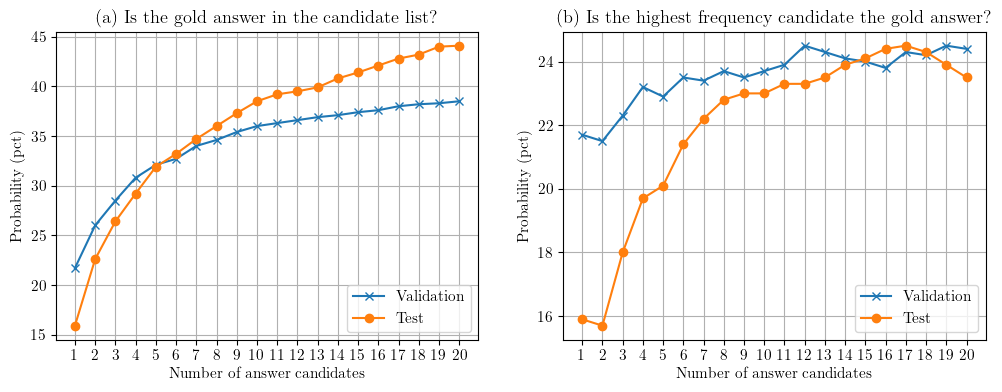

In [68]:
latex_pdf_graphic = {
  "pgf.texsystem": "pdflatex",
  'font.family': 'serif',
  'font.size' : 11,
  'text.usetex': True,
  'pgf.rcfonts': False,
}

with matplotlib.rc_context():
  matplotlib.rcParams.update(latex_pdf_graphic)
  plt = make_all_plots(plt)
  plt.savefig(#'./experiments/formalisation_heatmap.pdf', 
              './paper/2024-09-28_ICLR/answer_candidates_scoring.pdf', 
              bbox_inches='tight', pad_inches=0.1,
             )
  plt.show()
  plt.close('all')

In [ ]:
PAUSE

### Generate some candidates, etc, for 'Do-over training'

In [ ]:
data_train =load_cryptonite_dataset('train')
shuffled_idx_train = get_shuffled_idx(data_train, seed=42)

if True:
  run_samples(get_answer_response_multiple, 
              'llama3.1-it_answer_guesser_1200_steps_resp-only_train', 
              #'gemma2-9B_answer_guesser_1200_steps_resp-only_train', 
              data_train, shuffled_idx_train, samples=10000, )
  #ABOVE :    num_return_sequences=8, remaining_attempts=1)  # Only do loop once...  (8 total results)
  # Takes ~25mins for 1000

In [ ]:
import random

def get_some_entries(arr, max_entries=4):
  if len(arr)==0: return []
  random.shuffle(arr)  # in-place!
  return arr[:min(max_entries, random.randint(1, len(arr)))]  # At least 1 entry

def make_do_over_dataset(flog_arr, fout, n_do_overs=4, ):
  overlaid = solver.dataset.read_log_results(flog_arr)

  with open(fout, 'w', encoding='utf8') as fout_file:
    for idx, model_outputs in overlaid.items():
      #item = data_set[shuffled_idx[idx]]  
      item = data_train[shuffled_idx_train[idx]]  
      ans_data  = item['answer'].upper()
      #print(f'@{idx: <4d} Model:"{ans_model}", Correct:"{ans_data}"')
      model_data = model_outputs[0]
      a_invalid       = set( model_data['answers_valid'] )  
      a_invalid.discard(ans_data) # Strip out the correct answer(s)
      a_wrong_pattern = set( model_data['answers_wrong_pattern'] )
      a_in_clue       = set( model_data['answers_in_clue'] )
      
      for _ in range(n_do_overs): # Try to get this many out, if possible
        answers=[]
        a_wrong = get_some_entries(list(a_invalid)+list(a_wrong_pattern)+list(a_in_clue))
        # Now have some incorrect answers, let's write them out with annotations
        for a in a_wrong:
          reason=None 
          if a in a_invalid: 
            reason='wordplay'
            a_invalid.discard(a)
          if a in a_wrong_pattern: 
            reason='pattern'
            a_wrong_pattern.discard(a)
          if a in a_in_clue:
            reason='given'
            a_in_clue.discard(a)
          answers.append(a+' # No : '+reason)
        # Finally
        answers.append(ans_data)  # Correct!  +' '
        #print('\n'.join(answers)+'\n')

        item.update(dict(answers=answers))
        json.dump(item, fout_file, ensure_ascii=False)
        fout_file.write('\n')
  
        if len(a_wrong)==0:  # There are no entries left to choose...
          break
      #if idx>5: break  # Just do first few

#split='do-over-llama3.1-it-v1' # 0...1000
split='do-over-llama3.1-it-v2'  # 1000...9000
#split='do-over-gemma2-v1'
make_do_over_dataset([
  #'./experiments/zero-shot/llama3.1-it_answer_guesser_1200_steps_resp-only_train/2024-09-04_15-43-52.log', 
  './experiments/zero-shot/llama3.1-it_answer_guesser_1200_steps_resp-only_train/2024-09-05_03-00-19.log', 
  #'./experiments/zero-shot/gemma2-9B_answer_guesser_1200_steps_resp-only_train/2024-09-03_15-50-31.log',
], f'./data_orig/cryptonite-{split}.jsonl' )
"DONE"

In [ ]:
#for s in [set([]), set(['AS']), set(['AS','BF','CE', 'DW']), ]:
#  print(s, get_some_entries(s))
# random.shuffle(list({'AS'}))
# {'AS', 'BF', 'CE', 'DW'}.update({'AS'})